# Eco-focused office supply recommendation engine

The main goal of this code is to extract important features of each product and apply supervised machine learning to create Machine Learning model. 
A user can input a text to look for an object. The input goes to the model and picks up a relevant class. 
The next important step is to group and order the product in a particular class and recommend the product in desired order.
In this project, to recommend eco-friendly supplies, we choose product with highest eco-star with lowest price first. 

Note 1: An exhaustive search method could be applied to meet the objective of the project. In this however, exhaustive search is not a scalable approach. Therefore, Machine Learning model has been used to solve the problem. 

Note 2: In the present model user can't search product by SKUs. Because each item has unique SKU, machine learning is not suitable method. So there must be separate exhaustive search routine to take care of SKUs.

Note 3: Please visit the page below to check the functionality. Please input some words like "Dish Soap" and "Submit".
Please click "Show Lowest Price Items" to see the product with lowest price.
http://www.officesupplyrecom.space
  
Note4: Current model gives 93% accuracy to find "Class Name" and 89% accuracy to find "Sub Class Name". There are about 219 "Class Name" and 1100 "Sub Class Name". This accuracy can be improved using different machine learning model (such as Naive Bayes), using more features in the data (such as price). Also, hierarchical classification could be used to make it better. Improvement requires more research and further close meeting with the RawOffice teams.

Note5: Provided a time of 3 weeks, this is a best POC the author could provide. The front end ("http://www.officesupplyrecom.space") helps to discover where and how the model fails to predict correct class.


# Import important libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse

from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

import nltk

import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# Data Source

Provided data was from the excel file: "Combined-SPData-Price-Category-RawScore.xlsx", sheet_name "USA-PRICING"

In [2]:
Com_SP_Richards = pd.read_excel("data/Combined-SPData-Price-Category-RawScore.xlsx", sheet_name="USA-PRICING")

In [3]:
#print(list(Com_SP_Richards))

In [4]:
print(Com_SP_Richards.shape)
#There are only (48877, 147) points.

(48877, 147)


In [5]:
for i in range (Com_SP_Richards.shape[1]):
    if list(Com_SP_Richards)[i] =='Stripped Stock Number':
        print(i)
#Stripped Stock Number  appears in column 49 and SKU appears in 107

49


In [6]:
count=0
for i in range(Com_SP_Richards.shape[0]):
#for i in range(10):
    if (Com_SP_Richards.iloc[i][49] != Com_SP_Richards.iloc[i][107]):
        count+=1
        #print (Com_SP_Richards.iloc[i][49], Com_SP_Richards.iloc[i][107])
print ("Total unmatched SKU", count)

#Total unmatched SKU 2496. Some have slightly different SKUs and some of Com_SP_Richards.iloc[i][107] are nan

Total unmatched SKU 2496


In [7]:
Com_SP_Richards_subset = Com_SP_Richards[['Product Specifications','Desc1','RawScore','Promo Level 3 Dealer Cost','Class Name', 'Sub Class Name']]

In [8]:
Com_SP_Richards_subset.head()

,Product Specifications,Desc1,RawScore,Promo Level 3 Dealer Cost,Class Name,Sub Class Name
0,<div> <b>General Information</b> <hr> <span...,At-A-Glance June Academic Weekly Monthly Plann...,4.0,9.43,Calendars & Refills,Appointment Books & Planners
1,<div> <b>General Information</b> <hr> <span...,At-A-Glance June Academic Monthly Planner - Ac...,4.0,8.80,Calendars & Refills,Appointment Books & Planners
2,<div> <b>General Information</b> <hr> <span...,At-A-Glance June Academic Weekly Monthly Plann...,4.0,10.67,Calendars & Refills,Appointment Books & Planners
3,<div> <b>General Information</b> <hr> <span...,At-A-Glance Cityscape Academic Weekly/Monthly ...,4.0,10.45,Calendars & Refills,Appointment Books & Planners
4,<div> <b>General Information</b> <hr> <span...,At-A-Glance Cityscape Academic Professional Mo...,4.0,11.10,Calendars & Refills,Appointment Books & Planners


Product name is not explicitly found anywhere except in Product Specifications. Therefore, the regular expression has been used to select "Product Name" from the entire string. 

In [9]:
import re
from re import finditer
def apply_reg_exp_to_extract_name(string):
    pat = r'<span>Product Name</span>: (.*)' #Pattern Between which Name Of the product is 
    try:
        first = re.search(pat, string)
        for match in finditer(r'<br/>(.*)', first[1]):
            end= match.span()
            return first[1][1:end[0]]
    except:
            return ' '

In [10]:
import re
from re import finditer
Com_SP_Richards_subset['Product Specifications'] = Com_SP_Richards_subset['Product Specifications'].apply(apply_reg_exp_to_extract_name)

/Users/prabhatb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
Com_SP_Richards_subset["Features"] = Com_SP_Richards_subset["Product Specifications"] +' '+ Com_SP_Richards_subset["Desc1"]

/Users/prabhatb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now the product specification has just "Product Name" and non other informations. And in the input "Features" of the Machine Learning model "Product Specification" and "Desc1" have been combined. 

In [12]:
Com_SP_Richards_subset.head()

,Product Specifications,Desc1,RawScore,Promo Level 3 Dealer Cost,Class Name,Sub Class Name,Features
0,June Academic Weekly Monthly Planner,At-A-Glance June Academic Weekly Monthly Plann...,4.0,9.43,Calendars & Refills,Appointment Books & Planners,June Academic Weekly Monthly Planner At-A-Glan...
1,June Academic Monthly Planner,At-A-Glance June Academic Monthly Planner - Ac...,4.0,8.80,Calendars & Refills,Appointment Books & Planners,June Academic Monthly Planner At-A-Glance June...
2,June Academic Weekly Monthly Planner,At-A-Glance June Academic Weekly Monthly Plann...,4.0,10.67,Calendars & Refills,Appointment Books & Planners,June Academic Weekly Monthly Planner At-A-Glan...
3,Cityscape Academic Weekly/Monthly Planner,At-A-Glance Cityscape Academic Weekly/Monthly ...,4.0,10.45,Calendars & Refills,Appointment Books & Planners,Cityscape Academic Weekly/Monthly Planner At-A...
4,Cityscape Academic Professional Monthly Planner,At-A-Glance Cityscape Academic Professional Mo...,4.0,11.10,Calendars & Refills,Appointment Books & Planners,Cityscape Academic Professional Monthly Plann...


# Data Pre-Processing

We standardize text using regular expression

In [25]:
def standardize_text(string):
    string =str(string)
    string =string.replace(r"http\S+", "")
    string =string.replace(r"http", "")
    string =string.replace(r"@\S+", "")
    string =string.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    string =string.replace(r"@", "at")
    string =string.replace(r"&", "and")
    string =string.lower()
    
    return string

In [26]:
Com_SP_Richards_subset['Features'] = Com_SP_Richards_subset['Features'].apply(standardize_text)

In [27]:
Com_SP_Richards_subset['Features'].head()

0    june academic weekly monthly planner at-a-glan...
1    june academic monthly planner at-a-glance june...
2    june academic weekly monthly planner at-a-glan...
3    cityscape academic weekly/monthly planner at-a...
4    cityscape academic professional monthly  plann...
Name: Features, dtype: object

In [28]:
#Checking correctiness
Com_SP_Richards_subset.iloc[3853]['Class Name']

'Teaching Supplies'

In [29]:
#Remove all NaN values in the data
Com_SP_Richards_subset= Com_SP_Richards_subset.dropna()

In [30]:
Com_SP_Richards_subset= Com_SP_Richards_subset[~Com_SP_Richards_subset.isin(['NaN', 'NaT','nan','NAN']).any(axis=1)]

In [31]:
#Before classification, the "Sub Class Name" have been converted to labels 0 through 1012
Com_SP_Richards_subset["Sub Class Label"] = Com_SP_Richards_subset["Sub Class Name"].astype('category')
Com_SP_Richards_subset["Sub Class Label"]= Com_SP_Richards_subset["Sub Class Label"].cat.codes.values


In [32]:
Com_SP_Richards_subset["Sub Class Label"].min()

0

In [33]:
Com_SP_Richards_subset["Sub Class Label"].max()

1012

In [34]:
#Cross check if there are still any NaN in data
nan_count =0
for i in range (Com_SP_Richards_subset.shape[0]):
#for i in range (10):
    if Com_SP_Richards_subset.iloc[i][7]==-1:
        nan_count +=1
        #print (i, Com_SP_Richards_subset.iloc[i][7])
print ("nan Counts:  ", nan_count)
#Before dropping nan there were 47 nan class or subclass

nan Counts:   0


In [35]:
Com_SP_Richards_subset.shape

(47613, 8)

In [36]:
Com_SP_Richards_subset['Sub Class Label'].nunique()
#There are 1013 unique classes in the data

1013

In [37]:
Com_SP_Richards_subset.head()

,Product Specifications,Desc1,RawScore,Promo Level 3 Dealer Cost,Class Name,Sub Class Name,Features,Sub Class Label
0,June Academic Weekly Monthly Planner,At-A-Glance June Academic Weekly Monthly Plann...,4.0,9.43,Calendars & Refills,Appointment Books & Planners,june academic weekly monthly planner at-a-glan...,31
1,June Academic Monthly Planner,At-A-Glance June Academic Monthly Planner - Ac...,4.0,8.80,Calendars & Refills,Appointment Books & Planners,june academic monthly planner at-a-glance june...,31
2,June Academic Weekly Monthly Planner,At-A-Glance June Academic Weekly Monthly Plann...,4.0,10.67,Calendars & Refills,Appointment Books & Planners,june academic weekly monthly planner at-a-glan...,31
3,Cityscape Academic Weekly/Monthly Planner,At-A-Glance Cityscape Academic Weekly/Monthly ...,4.0,10.45,Calendars & Refills,Appointment Books & Planners,cityscape academic weekly/monthly planner at-a...,31
4,Cityscape Academic Professional Monthly Planner,At-A-Glance Cityscape Academic Professional Mo...,4.0,11.10,Calendars & Refills,Appointment Books & Planners,cityscape academic professional monthly plann...,31


It can clearly be seen in the table that "Features" and "Sub Class Label" are new features developed

# Macnine Learning

In [38]:
#Randimize the data before processing further. 
#Com_SP_Richards_subset= Com_SP_Richards_subset.sample(frac=1)

In [39]:
Com_SP_Richards_subset[['Desc1', 'Sub Class Name','Promo Level 3 Dealer Cost','RawScore']].head()

,Desc1,Sub Class Name,Promo Level 3 Dealer Cost,RawScore
0,At-A-Glance June Academic Weekly Monthly Plann...,Appointment Books & Planners,9.43,4.0
1,At-A-Glance June Academic Monthly Planner - Ac...,Appointment Books & Planners,8.80,4.0
2,At-A-Glance June Academic Weekly Monthly Plann...,Appointment Books & Planners,10.67,4.0
3,At-A-Glance Cityscape Academic Weekly/Monthly ...,Appointment Books & Planners,10.45,4.0
4,At-A-Glance Cityscape Academic Professional Mo...,Appointment Books & Planners,11.10,4.0


In [40]:
print(Com_SP_Richards_subset)

                                 Product Specifications  \
0                  June Academic Weekly Monthly Planner   
1                         June Academic Monthly Planner   
2                  June Academic Weekly Monthly Planner   
3             Cityscape Academic Weekly/Monthly Planner   
4      Cityscape Academic Professional Monthly  Planner   
5             Cityscape Academic Weekly/Monthly Planner   
6                   Mia Academic Weekly Monthly Planner   
7              Penelope Academic Weekly/Monthly Planner   
8                Aspire Academic Weekly/Monthly Planner   
9                Aspire Academic Weekly/Monthly Planner   
10                Ombre Academic Weekly/Monthly Planner   
11                         Blush Weekly/Monthly Planner   
12                         Blush Weekly/Monthly Planner   
13                        Ingrid Weekly/Monthly Planner   
14                        Ingrid Weekly/Monthly Planner   
15                       Cecilia Weekly/Monthly Planner 

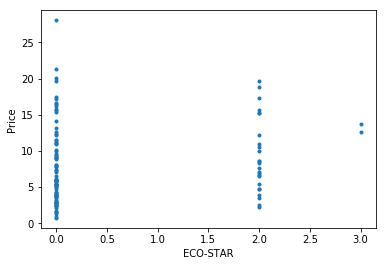

In [43]:
#Because single class has different product with wide range of price, it is hard to come up with special trend of price
#vs eco-sttar
gb = Com_SP_Richards_subset.groupby("Sub Class Name")
a_group=gb.get_group("Sheet Protectors")

plt.plot(a_group['RawScore'],a_group['Promo Level 3 Dealer Cost'],".")
plt.xlabel('ECO-STAR')
plt.ylabel('Price')
plt.show()

In [44]:
#Save data to Predict, Group and Sort.
Com_SP_Richards_subset.to_csv("complete_data_set_for_Name_Score_price.csv")

In [45]:
#Split data in training and testing. Just use column 6: "Features" and "column 7: "Sub Class Name"
X_train, X_test, y_train, y_test = train_test_split(Com_SP_Richards_subset.iloc[:,6].values, Com_SP_Richards_subset.iloc[:,7].values, test_size=0.2,random_state=40)

In [46]:
#Test that proper values are used:
X_train

array(['bn6000 time clock uattend bn6000 time clock - biometric - 5000 employees',
       'managerial mid-back chair lorell managerial mid-back chair - fabric seat - black back - 5-star base - green - 25.3" width x 23.5" depth x 40.5" height',
       'advantus roll midgees candy tootsie advantus roll midgees candy - chocolate - individually wrapped, gluten-free, peanut-free - 5 lb - 1 bag',
       ...,
       'global harmonized system sds center kit skilcraft global harmonized system sds center kit',
       'blue copy red date stamp base xstamper blue copy red date stamp base - 1 each - blue, red ink',
       '16" stack chair, chrome legs ecr4kids 16" stack chair, chrome legs - steel back - four-legged base - red - plastic, steel - 17.3" width x 17.3" depth x 28.8" height'],
      dtype=object)

In [47]:
y_train

array([ 41, 564, 124, ..., 780, 849, 383], dtype=int16)

# Machine Learning Pipeline

This pipeline contains two main components:
    1. Natural Language Processing:
            a. CountVectorizer()
            b. TfidfTransformer()
    and
    2. Classification:
            a. LogisticRegression. The parameters are carefully tuned to get better performance. 
            b. MultinomialNB. This is very fast method if we want to model very-vety fast. It is weak in performance. 

In [64]:
#Test:
#In current model Logistic regression is used.
count_vect = CountVectorizer()
tf = TfidfTransformer(use_idf=False)
tfidf = TfidfTransformer()
nb  = MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)
lr = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                        multi_class='multinomial', n_jobs=-1, random_state=40)

#print(X_train)

p = Pipeline([ 
    ('count_vect',count_vect),
    #('tf',tf),
    #('tfidf', tfidf),
    #('lr', lr)
    #('nb',nb)
])
test = p.fit_transform(X_train)
#print(test.toarray() )
for i in range(1000):
    if test.toarray()[0][i]:
        print (test.toarray()[0][i])

In [127]:
#In current model Logistic regression is used.
count_vect = CountVectorizer()
tf = TfidfTransformer(use_idf=False)
tfidf = TfidfTransformer()
nb  = MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)
lr = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                        multi_class='multinomial', n_jobs=-1, random_state=40)


p = Pipeline([ 
    ('count_vect',count_vect),
    ('tf',tf),
    ('tfidf', tfidf),
    ('lr', lr)
    #('nb',nb)
])



Model is main model of classification. We save it to file to use it in front end.

In [54]:
#This model takes upto half hour to run
#model = p.fit(X=X_train,y=y_train)

In [55]:
# save the model to disk
# We bring this model to front end.
import joblib
filename = 'new_data_finalized_lr_model_wPipe.sav'
joblib.dump(model, open(filename, 'wb'))

In [57]:
#Test reading the saved model
import joblib
loaded_model = joblib.load(filename)
result = loaded_model.predict(X_test)
print (result)

[ 851  398  818 ... 1004  529  562]


In [59]:
#Manual test on how it classifies
#Enter any word or phrase withing commas to find the result class
product_name_phrase = "Chips"
out_arr = loaded_model.predict([product_name_phrase])
print (out_arr)
Com_SP_Richards_subset['Sub Class Name'].loc[Com_SP_Richards_subset['Sub Class Label']==out_arr[0]].unique()[0]

[826]


'Snacks'

In [60]:
#Create an array of y-predicted
y_predicted = model.predict(X_test)

# Validation

Test Classification accuracy, precision, recall and f1-score

In [125]:
def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

#accuracy = 0.893, precision = 0.901, recall = 0.893, f1 = 0.892 for LR C=30.0

# Note that this accuracy goes to 93% when we use "Class Name" as predictor insted of "Sub Class Name" that has 
# currenly been used.


accuracy = 0.893, precision = 0.901, recall = 0.893, f1 = 0.892


/Users/prabhatb/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/prabhatb/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/prabhatb/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/prabhatb/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[[ 6  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  2]]


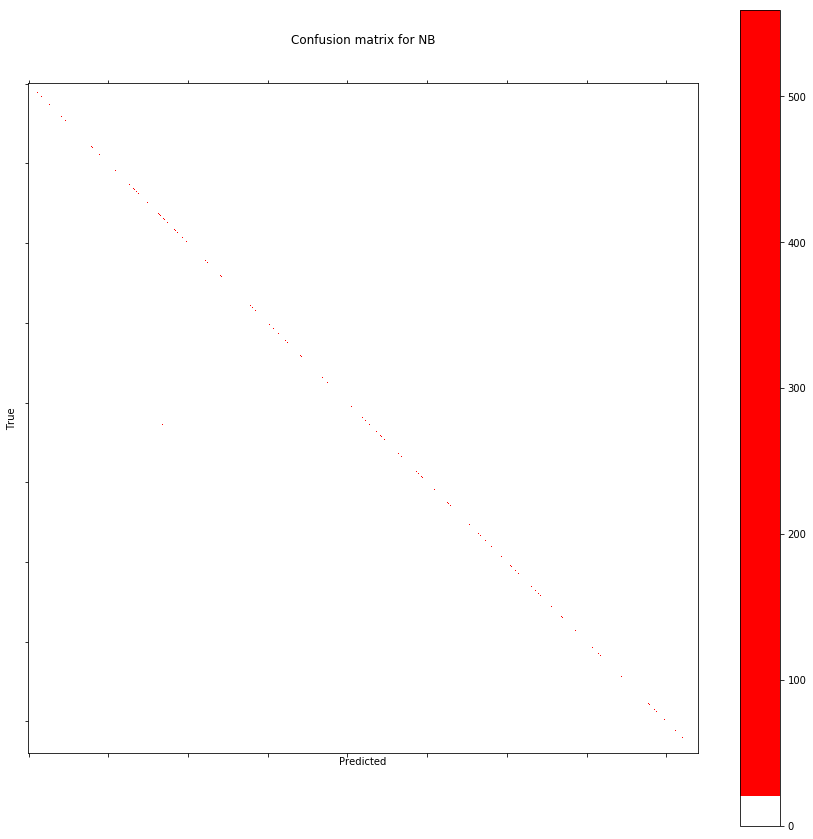

In [99]:
#See the confusion matrix. In careful observation we can see a line in diagonal from left top to right bottom.
#Note: Confusion matrix is not useful way to visualize validation in such case of large number of classes. 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
labels = ['']
cm = confusion_matrix(y_test, y_predicted)
print(cm)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cmap = ListedColormap(['w','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r'])
cax = ax.matshow(cm,cmap=cmap)
plt.title('Confusion matrix for NB')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
#fig.savefig('confusion_matrix.png', bbox_inches='tight')

In [100]:
#Save Data 
complete_data = pd.read_csv('complete_data_set_for_Name_Score_price.csv')

# Tests

Final test before deploying model

In [101]:
product_name_phrase = "Table"
out_arr = loaded_model.predict([product_name_phrase])
print (out_arr)
sub_class =complete_data['Sub Class Name'].loc[complete_data['Sub Class Label']==out_arr[0]].unique()[0]
print (sub_class)


[702]
Play Tables


In [114]:
#Group product by "Sub Class Name"
gb = complete_data.groupby("Sub Class Name")
#Take "Sub Class" predicted using product_name_phrase and classification model
a_group = gb.get_group(sub_class)
#Sort the values such that eco-star is sorted from highest to lowest while the cost in lowest to highest order
sorted_a_higheco_group =a_group.sort_values(['RawScore','Promo Level 3 Dealer Cost'],ascending=[0,1])

first_recomm = sorted_a_higheco_group.iloc[0][1]
second_recomm = sorted_a_higheco_group.iloc[1][1]
third_recomm = sorted_a_higheco_group.iloc[2][1]

In [115]:
print (first_recomm,'   ', second_recomm,'   ',third_recomm )

Natural Birch 3-piece Play Kitchen Set     Housecleaning Set-n-Rack     Mesa Activity Table


In [116]:
first_recomm = sorted_a_higheco_group.iloc[0][3]
second_recomm = sorted_a_higheco_group.iloc[1][3]
third_recomm = sorted_a_higheco_group.iloc[2][3]

In [117]:
print (first_recomm,'   ', second_recomm,'   ',third_recomm )

5.0     4.0     4.0


In [118]:
first_recomm = sorted_a_higheco_group.iloc[0][4]
second_recomm = sorted_a_higheco_group.iloc[1][4]
third_recomm = sorted_a_higheco_group.iloc[2][4]

In [107]:
print (first_recomm,'   ', second_recomm,'   ',third_recomm )

759.92     106.05     169.52


In [119]:
#Sort the values such that eco-star is sorted from lowest to highest and also the cost in lowest to highest order
sorted_a_logheco_group =a_group.sort_values(['RawScore','Promo Level 3 Dealer Cost'],ascending=[1,1])
last_recomm = sorted_a_logheco_group.iloc[0][1]
second_last_recomm = sorted_a_logheco_group.iloc[1][1]
third_last_recomm = sorted_a_logheco_group.iloc[2][1]

In [120]:
print (last_recomm,'   ', second_recomm,'   ',third_recomm )

Activity Table     106.05     169.52


In [121]:
last_recomm = sorted_a_logheco_group.iloc[0][3]
second_last_recomm = sorted_a_logheco_group.iloc[1][3]
third_last_recomm = sorted_a_logheco_group.iloc[2][3]

In [122]:
print (last_recomm,'   ', second_last_recomm,'   ',third_last_recomm )

0.0     0.0     0.0


In [123]:
last_recomm = sorted_a_logheco_group.iloc[0][4]
second_last_recomm = sorted_a_logheco_group.iloc[1][4]
third_last_recomm = sorted_a_logheco_group.iloc[2][4]

In [124]:
print (last_recomm,'   ', second_last_recomm,'   ',third_last_recomm )

169.52     169.52     169.52


# Note: please use two files for front end production:

    1. new_data_finalized_lr_model_wPipe.sav
and
    2. complete_data_set_for_Name_Score_price.csv
    



Authors Note:
    Very interesting project. Author thinks that this problem meets requirement if Machine Learning is blended well with Softeare Engineering.